In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import os
from pathlib import Path
from plaid.evaluation import batch_rmsd_calculation, run_tmalign, RITAPerplexity, batch_rmspd_from_pdb_paths
from plaid.utils import extract_avg_b_factor_per_residue, read_sequences_from_fasta
import numpy as np
import matplotlib.pyplot as plt

root_sample_dir = Path("/data/lux70/plaid/artifacts/samples/by_length/")

In [12]:
all_dfs = {}

for length in os.listdir(root_sample_dir):
    sample_dir = root_sample_dir / length
    df = pd.read_csv(sample_dir / "designability.csv")
    all_dfs[int(length)] = df

In [15]:
print(len(all_dfs))
print(all_dfs.keys())
all_dfs[32].head()

36
dict_keys([40, 108, 96, 72, 172, 140, 116, 88, 124, 120, 68, 112, 144, 76, 92, 44, 168, 160, 152, 104, 136, 36, 128, 52, 84, 60, 64, 80, 56, 148, 32, 48, 132, 100, 156, 164])


,Unnamed: 0,pdb_paths,sequences,inverse_generated_pdb_paths,phantom_generated_pdb_paths,plddt,ccrmsd,scrmsd,cctm,sctm,designable,perplexity,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH
0,0,/data/lux70/plaid/artifacts/samples/by_length/...,QRMAGIWADLLGLRRVGVRDSFFELGGDSIMSLQLVERARGAGLPL...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,73.284277,0.091816,0.091816,0.99888,0.99888,True,6.093750,7122.2955,0.062500,47.112500,11.698965,0.021875,3.856169
1,1,/data/lux70/plaid/artifacts/samples/by_length/...,GKYQIGGVPDGAKGERLTPEALDYVGLLHRLFSSRRISLLSQREHK...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,50.418323,5.691837,5.691837,0.59505,0.59505,False,16.666278,7192.1143,0.062500,34.587500,9.226667,-0.610938,1.945932
2,2,/data/lux70/plaid/artifacts/samples/by_length/...,CVCDGHAERCFIRRLTRDANKAYPETWCIECSHGTMGDYCEKCMPH...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,67.839591,3.669174,3.669174,0.79190,0.79190,False,18.571555,7424.3129,0.125000,58.190781,5.436275,-0.657813,-3.044961
3,3,/data/lux70/plaid/artifacts/samples/by_length/...,DYYSLLNVPQSASKKEIKTAYRKLALKYHPDKNADNPNAEEKFKNL...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,84.917634,0.059241,0.059241,0.99953,0.99953,True,4.756112,7428.1131,0.109375,37.481250,8.843725,-1.345313,1.850928
4,4,/data/lux70/plaid/artifacts/samples/by_length/...,KKEGIYRHLSGSYARDAYGLYHGEQRIEAAKPISFTMVSMNLFRDQ...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,44.938960,1.547409,1.547409,0.80107,0.80107,True,19.221742,7373.1784,0.109375,31.454688,8.264025,-0.853125,1.031109


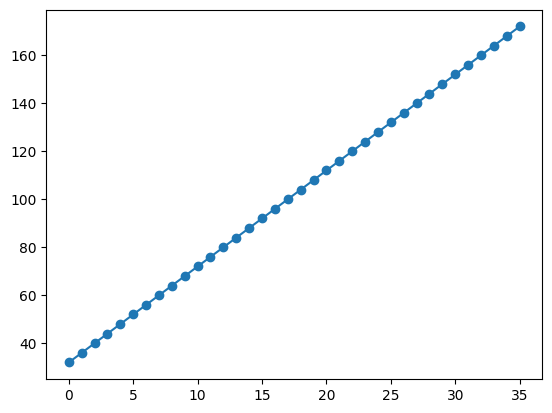

In [26]:
# quick sanity check
lengths = list(all_dfs.keys())
lengths.sort()
lengths = np.array(lengths)
plt.plot(lengths, marker="o")

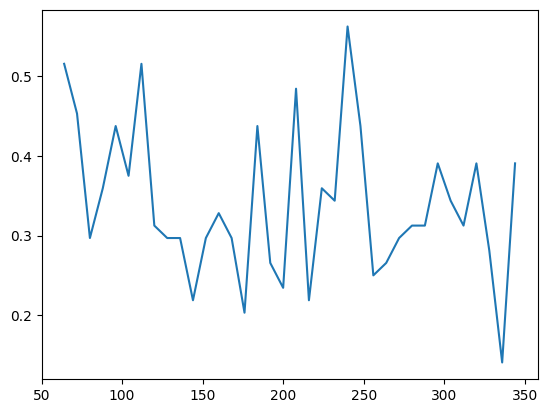

In [30]:
designable_frac = []
for length in lengths:
    df = all_dfs[length]
    des_fr = df.designable.sum() / len(df)
    designable_frac.append(des_fr)
plt.plot(lengths * 2,designable_frac)

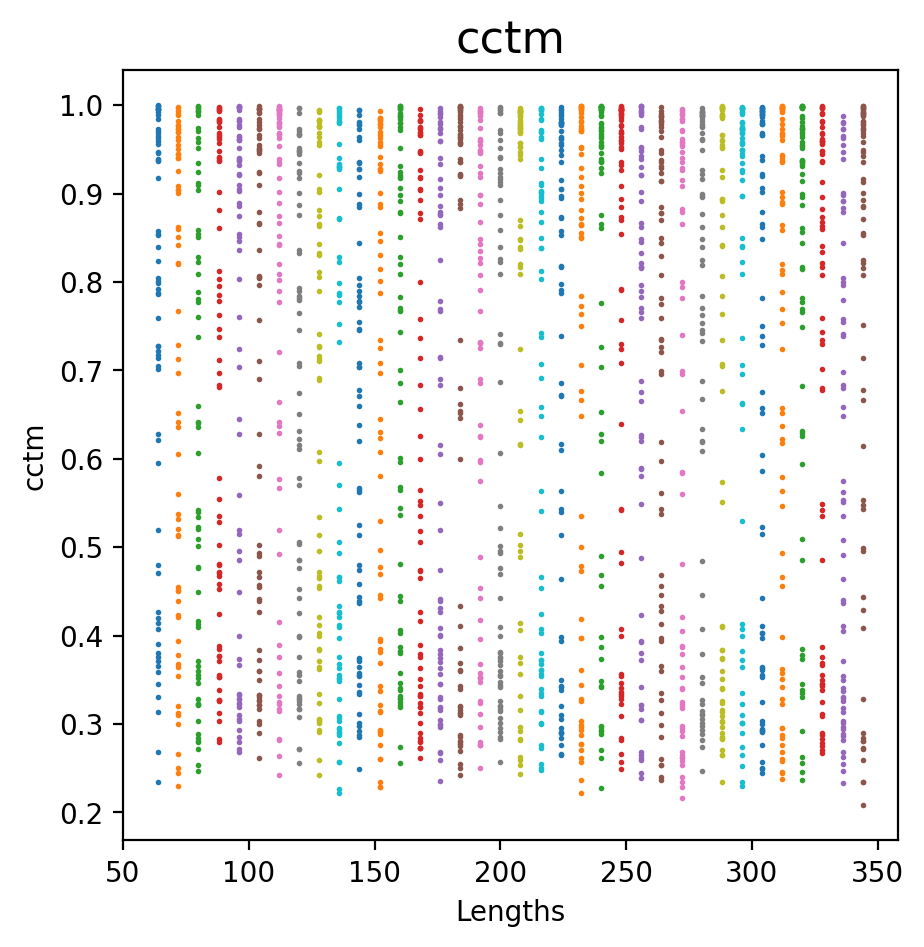

In [33]:
fig, ax = plt.subplots(1,1,dpi=200,figsize=(5,5))

metric = "cctm"

for length in lengths:
    df = all_dfs[length]
    ax.scatter([length * 2] * len(df), df[metric].values, s=1)

ax.set_xlabel("Lengths")
ax.set_ylabel(metric)
ax.set_title(metric, fontsize=16)
plt.show()

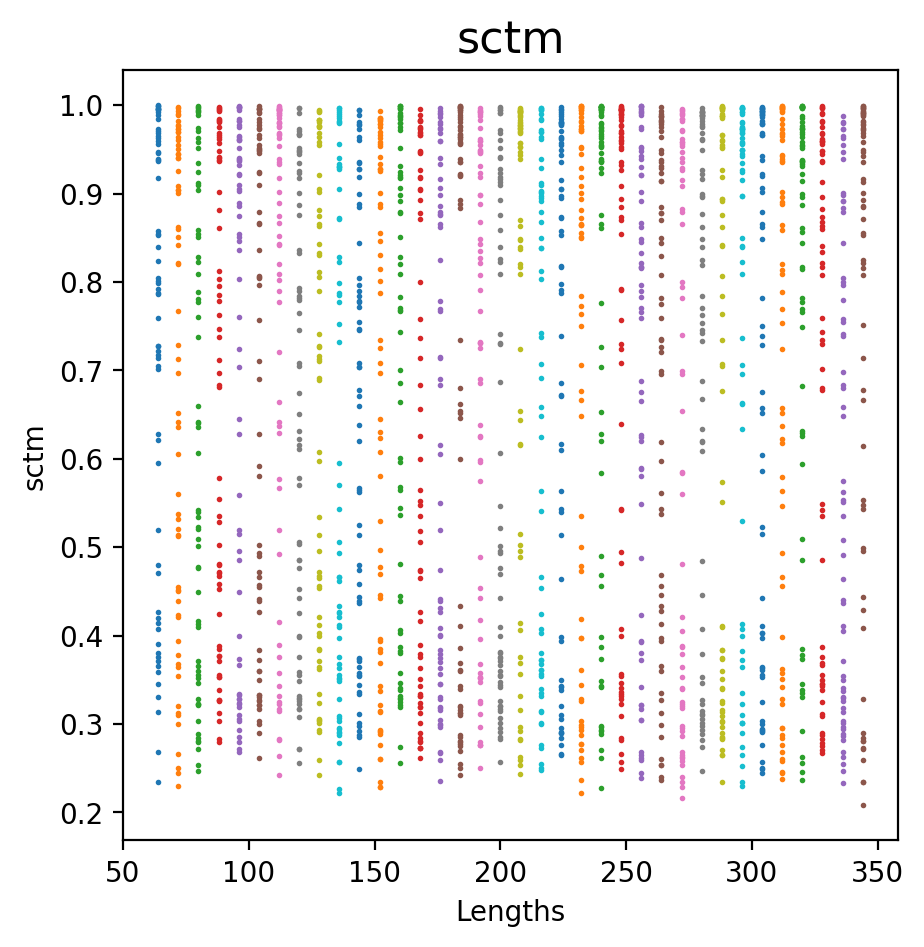

In [34]:
fig, ax = plt.subplots(1,1,dpi=200,figsize=(5,5))

metric = "sctm"

for length in lengths:
    df = all_dfs[length]
    ax.scatter([length * 2] * len(df), df[metric].values, s=1)

ax.set_xlabel("Lengths")
ax.set_ylabel(metric)
ax.set_title(metric, fontsize=16)
plt.show()

In [54]:
samplesdir = Path("/data/lux70/plaid/baselines/protpardelle/samples_100_200_300/inverse_generated/structures")
newdir = Path("/data/lux70/plaid/baselines/protpardelle/samples_100_200_300/inverse_generated/struct2")
pdbfiles = glob.glob(str(samplesdir / "*pdb"))

In [56]:
from Bio import PDB

import warnings
warnings.filterwarnings("ignore")

def count_residues_biopython(pdb_path):
    parser = PDB.PDBParser()
    structure = parser.get_structure('protein', pdb_path)
    residue_count = 0

    for model in structure:
        for chain in model:
            residue_count += len([residue for residue in chain if PDB.is_aa(residue)])

    return residue_count

len_tickers = {
    100: 0,
    200: 0,
    300: 0
}

for p in pdbfiles:
    n_res = count_residues_biopython(p)
    tick = len_tickers[n_res]
    filename = f"len{n_res}_samp{tick}.pdb"
    new_path = newdir / filename
    
    len_tickers[n_res] += 1
    os.rename(p, new_path)
    